In [1]:
from tfn.preprocess import Dataset
import os
os.chdir('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import re
from collections import Counter
import seaborn as sns
import string
import spacy
from spacy.lemmatizer import Lemmatizer

In [2]:
data = Dataset('twitter')

X_train, X_test = data.X_train, data.X_test
X = np.array(X_train + X_test)

y_train, y_test = data.y_train, data.y_test
y = np.array(y_train + y_test)


In [3]:
### PLOT SETUP ###

COLOR_0 = '#00203F'
COLOR_1 = '#ADEFD1'
TITLE_SIZE = 16
SUBTITLE_SIZE = 14
TICK_SIZE = 11

plt.style.use('seaborn-paper')

rcParams['font.size'] = TICK_SIZE

In [4]:
num_0 = y[y == 0].size
num_1 = y[y == 1].size

Text(0.5, 1.0, 'Proportion of Tweets')

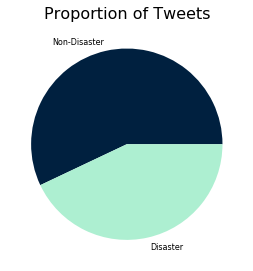

In [5]:
fig1, ax = plt.subplots()

ax.pie((num_0, num_1), labels=['Non-Disaster', 'Disaster'], colors=[COLOR_0, COLOR_1])
ax.set_title('Proportion of Tweets', fontsize=TITLE_SIZE)

# Most Frequent Words

C:\Apps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Apps\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 137 missing from current font.
  font.load_char(ord(s), flags=flags)


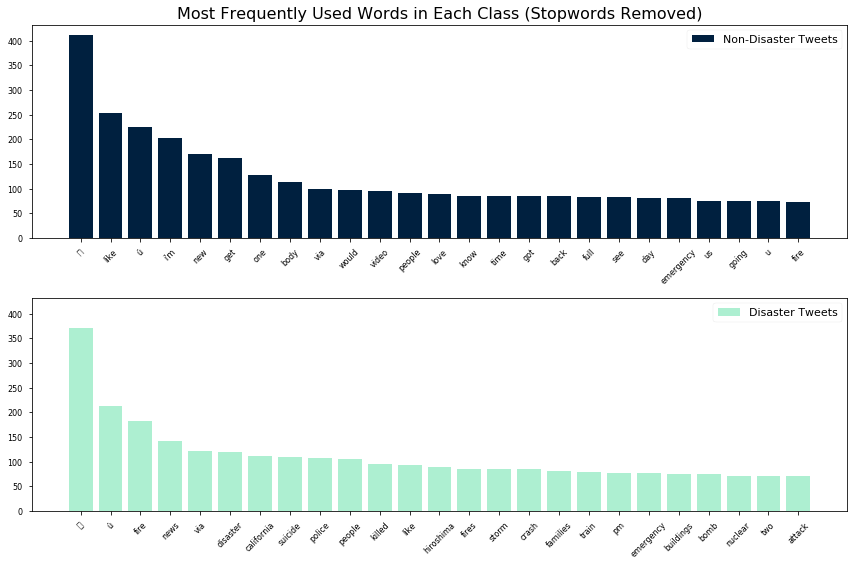

In [6]:
all_words_0 = []
all_words_1 = []
for i, _ in enumerate(X):
    if y[i] == 0:
        all_words_0 += X[i]
    elif y[i] == 1:
        all_words_1 += X[i]
    else:
        print('Hey, something weird\'s happening...')
        

c0 = list(Counter(all_words_0).items())
c0.sort(key=lambda x: x[1], reverse=True)

c1 = list(Counter(all_words_1).items())
c1.sort(key=lambda x: x[1], reverse=True)


fig2, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True)
ax[0].bar(*zip(*c0[:25]), color=COLOR_0, label='Non-Disaster Tweets')
ax[0].tick_params(axis='x', rotation=45)
ax[0].legend(fontsize=TICK_SIZE)
ax[1].bar(*zip(*c1[:25]), color=COLOR_1, label='Disaster Tweets')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(fontsize=TICK_SIZE)
ax[0].set_title('Most Frequently Used Words in Each Class (Stopwords Removed)', fontsize=TITLE_SIZE)
fig2.tight_layout()
#Maybe change colour based on sentiment of word?

# Emoji usage in each class

Text(0.5, 0.98, 'Percentage of tweets containing # Emojis')

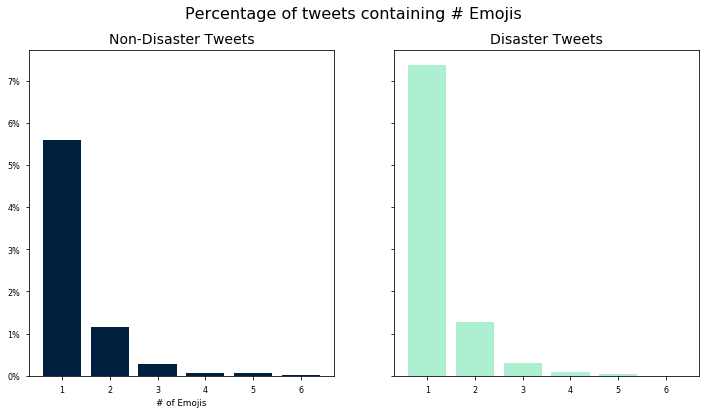

In [7]:
emoji_count_0 = []
emoji_count_1 = []

for i,x in enumerate(X):
    if y[i] == 0:
        emoji_count_0.append(x.count('\x89'))
    elif y[i] == 1:
        emoji_count_1.append(x.count('\x89'))

emoji_count_0 = Counter(emoji_count_0)
emoji_count_1 = Counter(emoji_count_1)

y_count = Counter(y)

emoji_count_0_prop = list({key: value / y_count[0] for key, value in emoji_count_0.items()}.items())
emoji_count_1_prop = list({key: value / y_count[1] for key, value in emoji_count_1.items()}.items())

emoji_count_0_prop.sort(key=lambda x: x[0])
emoji_count_1_prop.sort(key=lambda x: x[0])

emoji_count_0_prop = emoji_count_0_prop[1:]
emoji_count_1_prop = emoji_count_1_prop[1:]

fig3, ax = plt.subplots(1,2, figsize=(12,6), sharey=True, sharex=True)

ax[0].bar(*zip(*emoji_count_0_prop), color=COLOR_0)
ax[0].set_title('Non-Disaster Tweets', fontsize=SUBTITLE_SIZE)
ax[1].bar(*zip(*emoji_count_1_prop), color=COLOR_1)
ax[1].set_title('Disaster Tweets', fontsize=SUBTITLE_SIZE)

ax[0].get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))

ax[0].set_xlabel('# of Emojis')

fig3.suptitle('Percentage of tweets containing # Emojis', fontsize=TITLE_SIZE)

# Number of Words / URLs

In [8]:
df = pd.DataFrame(zip(X,y), columns=['X', 'y'])
df['Num Words'] = df['X'].apply(len)
df['Contains URL'] = df['X'].apply(lambda x: len(re.findall('https?://t\.co', ' '.join(x))))

summary = df.groupby('y').mean()

[Text(0, 0, 'Non-Disaster'), Text(0, 0, 'Disaster')]

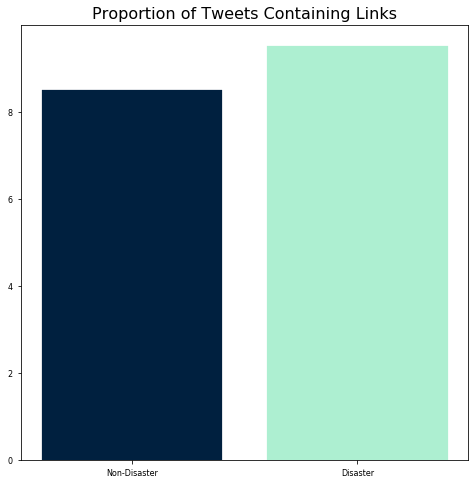

In [9]:
fig4, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(summary.index, summary['Num Words'].values)
barlist[0].set_color(COLOR_0)
barlist[1].set_color(COLOR_1)

ax.set_title('Proportion of Tweets Containing Links', fontsize=TITLE_SIZE)

ax.set_xticks([0,1])
ax.set_xticklabels(['Non-Disaster', 'Disaster'])

[Text(0, 0, 'Non-Disaster'), Text(0, 0, 'Disaster')]

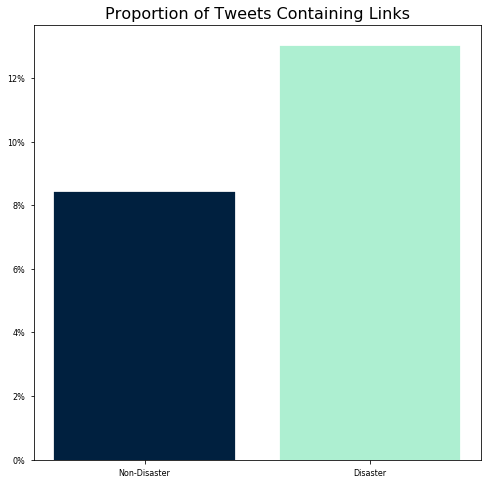

In [10]:
fig5, ax = plt.subplots(figsize=(8,8))
barlist = ax.bar(summary.index, summary['Contains URL'].values)
barlist[0].set_color(COLOR_0)
barlist[1].set_color(COLOR_1)
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(f'{int(100*x)}%')))
ax.set_title('Proportion of Tweets Containing Links', fontsize=TITLE_SIZE)

ax.set_xticks([0,1])
ax.set_xticklabels(['Non-Disaster', 'Disaster'])

Tweets referring to disasters are slightly longer in length than other tweets, comprising of around 9.5 words on average compared with 8.5 words for the latter.

Disaster tweets also contains links to external webpages 13.0% of the time - significantly more frequent than other tweets at 8.4%.

# POS & Punctuation Analysis

In [11]:
_TRAIN_DATA_PATH = 'tfn/data/train.csv'

In [12]:
raw_data = pd.read_csv(_TRAIN_DATA_PATH, header=0)
X_raw = raw_data['text'].to_numpy()
y_raw = raw_data['target'].to_numpy()

In [13]:
en = spacy.load('en_core_web_sm')
lemmatize = en.Defaults.create_lemmatizer()

In [ ]:
POS_LIST = ["ADJ", "ADP", "ADV", "AUX", "CONJ", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART", "PRON", "PROPN", "PUNCT", "SCONJ", "SYM", "VERB", "X", "SPACE"]            

punc = {0: Counter(), 1: Counter()}
pos = {0: Counter(), 1: Counter()}
for i, doc in enumerate(X_raw):
    punc[y[i]] += Counter([char for char in doc if char in string.punctuation])
    pos[y[i]] += Counter([token.pos_ for token in en(doc)])
    
punc['tot'] = punc[0] + punc[1]
pos['tot'] = pos[0] + pos[1]

for d in punc:
    punc[d] = dict(punc[d])
for d in pos:
    pos[d] = dict(pos[d])

for d in punc:
    for p in string.punctuation:
        if p not in punc[d]:
            punc[d][p] = 0
for d in pos:
    for p in POS_LIST:
        if p not in pos[d]:
            pos[d][p] = 0

In [ ]:
punc_sorted = [(k,v/y_raw.shape[0]) for k,v in punc['tot'].items()]
punc_sorted.sort(key=lambda x: x[1], reverse=True)

pos_sorted = [(k,v/y_raw.shape[0]) for k,v in pos['tot'].items()]
pos_sorted.sort(key=lambda x: x[1], reverse=True)


punc_sorted_0 = [(k,v/y_raw[y_raw==0].shape[0]) for k,v in punc[0].items()]
punc_sorted_0.sort(key=lambda x: list(zip(*punc_sorted))[0].index(x[0]))

punc_sorted_1 = [(k,v/y_raw[y_raw==1].shape[0]) for k,v in punc[1].items()]
punc_sorted_1.sort(key=lambda x: list(zip(*punc_sorted))[0].index(x[0]))


pos_sorted_0 = [(k,v/y_raw[y_raw==0].shape[0]) for k,v in pos[0].items()]
pos_sorted_0.sort(key=lambda x: list(zip(*pos_sorted))[0].index(x[0]))

pos_sorted_1 = [(k,v/y_raw[y_raw==1].shape[0]) for k,v in pos[1].items()]
pos_sorted_1.sort(key=lambda x: list(zip(*pos_sorted))[0].index(x[0]))

In [ ]:
def diff_func(a,b):
    m = max(a,b)
    if m > 0:
        return (a - b)/max(a,b)
    else:
        return 0

In [ ]:
N = len(list(zip(*punc_sorted_0))[1])
ind = np.arange(N)
width = 0.35

fig6, ax = plt.subplots(2,1, figsize=(16,12))

ax[0].bar(ind, list(zip(*punc_sorted_0))[1], width, color=COLOR_0, label='Non-Disaster')
ax[0].bar(ind+width, list(zip(*punc_sorted_1))[1], width, color=COLOR_1, label='Disaster')

ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(list(zip(*punc_sorted_0))[0])

ax[0].legend(loc='best')

ax[0].set_title('Punctuation Marks Per Tweet', fontsize=TITLE_SIZE)

color_0 = 'blue'
color_1 = 'orange'

N = len(list(zip(*punc_sorted_0))[1])
ind = np.arange(N)
width = 0.7

the_data = [diff_func(a,b) for a,b in zip(list(zip(*punc_sorted_0))[1],list(zip(*punc_sorted_1))[1])]

ax[1].bar(ind, the_data, width,
      color=[COLOR_0 if x > 0 else COLOR_1 for x in the_data])

ax[1].set_xticks(ind)
ax[1].set_xticklabels(list(zip(*punc_sorted_0))[0])

ax[1].set_title('Difference in Punctuation Usage Per Tweet Between Disaster and non-Disaster Tweets', fontsize=TITLE_SIZE)

In [ ]:
N = len(list(zip(*pos_sorted_0))[1])
ind = np.arange(N)
width = 0.35

fig7, ax = plt.subplots(2,1, figsize=(16,12))

ax[0].bar(ind, list(zip(*pos_sorted_0))[1], width, color=COLOR_0, label='Non-Disaster')
ax[0].bar(ind+width, list(zip(*pos_sorted_1))[1], width, color=COLOR_1, label='Disaster')

ax[0].set_xticks(ind + width / 2)
ax[0].set_xticklabels(list(zip(*pos_sorted_0))[0])

ax[0].legend(loc='best')

ax[0].set_title('Part-Of-Speech Tags Per Tweet', fontsize=TITLE_SIZE)


N = len(list(zip(*pos_sorted_0))[1])
ind = np.arange(N)
width = 0.7

the_data = [diff_func(a,b) for a,b in zip(list(zip(*pos_sorted_0))[1],list(zip(*pos_sorted_1))[1])]

ax[1].bar(ind, the_data, width,
      color=[COLOR_0 if x > 0 else COLOR_1 for x in the_data])

ax[1].set_xticks(ind)
ax[1].set_xticklabels(list(zip(*pos_sorted_0))[0])

ax[1].set_title('Difference in Part-Of-Speech Usage Per Tweet Between Disaster and non-Disaster Tweets', fontsize=TITLE_SIZE)